In [1]:
%%markdown

# ErrorBarPlots

This file derives from ModelSwapping.ipynb but takes averages for some plots.


# ErrorBarPlots

This file derives from ModelSwapping.ipynb but takes averages for some plots.


In [1]:
import sveCacheSim as sim
import CacheModels
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

In [2]:
# Load Data
size='Large'
sizel = size.lower()
data = sim.load_object('DataPMBS20/{}AllModels10Runs.pkl'.format(size))
stats = {}
gold_file='gold_python3.7/base_{}_stats.pkl'.format(sizel)
stats['base'] = sim.load_object('gold_python3.7/base_{}_stats.pkl'.format(sizel))
stats['fr'] = data[sizel]['FR']
stats['m4'] = data[sizel]['M4']
stats['m8'] = data[sizel]['M8']
stats['all'] = data[sizel]['ALL']

In [3]:
# Check that the right stats were loaded
# Error should be ~3-4% for M8/All on Small Medium
# Error should be ~7-8% for M8/All on Large
sim.print_summary(stats['fr'][0], 'gold_python3.7/base_{}_stats.pkl'.format(sizel))
sim.print_summary(stats['m4'][0], 'gold_python3.7/base_{}_stats.pkl'.format(sizel))
sim.print_summary(stats['m8'][0], 'gold_python3.7/base_{}_stats.pkl'.format(sizel))
sim.print_summary(stats['all'][0], 'gold_python3.7/base_{}_stats.pkl'.format(sizel))


Summary:
 L1 percent change in hit count: -0.09%
 L2 percent change in hit count: 54.35%
 L3 percent change in hit count: -71.17%
 Percent change in cycles: -27.88%
Summary:
 L1 percent change in hit count: -0.37%
 L2 percent change in hit count: 46.10%
 L3 percent change in hit count: -51.74%
 Percent change in cycles: -23.22%
Summary:
 L1 percent change in hit count: -0.19%
 L2 percent change in hit count: 12.16%
 L3 percent change in hit count: -4.10%
 Percent change in cycles: -7.60%
Summary:
 L1 percent change in hit count: 0.07%
 L2 percent change in hit count: 10.14%
 L3 percent change in hit count: -4.89%
 Percent change in cycles: -7.91%


In [66]:
%%markdown

## Meabo Traces



## Meabo Traces


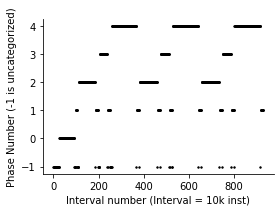

In [4]:
def plot_trace(ax, label, trace, axis_labels):
    ax.scatter([*range(len(trace))], trace,s=2, color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(label)
    if axis_labels:
        ax.set_ylabel('Phase Number (-1 is uncategorized)')
        ax.set_xlabel('Interval number (Interval = 10k inst)')

        
fig, ax = plt.subplots(figsize=(4,3))
#plot_trace(ax, '{} Trace'.format(size), stats['base'].phase_trace.trace, True)
plot_trace(ax, None, stats['base'].phase_trace.trace, True)
plt.tight_layout()


plt.savefig('DataPMBS20/plots_{}/phase_trace.pdf'.format(sizel))


In [5]:
%%markdown 

## Accuracy 

This time we'll average 10 runs



## Accuracy 

This time we'll average 10 runs


In [82]:
def get_acc(st1, st2, phase):
    # t1 is assumed to be from the base cache
    
    t1 = st1.cache_trace[0] # cache trace from st1
    t2 = st2.cache_trace[0] # cache trace from st2
    
    # Just get accesses where were are in phase `phase` and in state is Swapped (2)
    pick_state = t2['state'] == 2
    pick_phase = t2['phase'] == phase
    
    pick = np.logical_and(pick_state, pick_phase)
    
    # Get the hit/miss from each 
    t1_hits = t1['isHit'][pick]
    t2_hits = t2['isHit'][pick]
    
    num_correct = np.sum(np.equal(t1_hits, t2_hits))
    acc = num_correct / len(t1_hits)
    
    return acc

    
nphases = stats['base'].phase_trace.nphases
name_map={'fr':'Fixed Rate', 'm4': 'Markov 4', 'm8':'Markov 8', 'all':'All'}
data_mean = {}
data_std = {}
data_std_up = {}
data_std_down = {}

for name in stats:
    if name is 'base' or name is 'all':
        continue
    acc_mean = []
    acc_std = []
    for i in range(nphases):
        agg = []
        for j in range(len(stats[name])):
            agg.append(get_acc(stats['base'], stats[name][j], i))
        acc_mean.append(np.mean(agg))
        acc_std.append(np.std(agg))
    data_mean[name_map[name]] = acc_mean
    data_std[name_map[name]] = acc_std
    data_std_up[name_map[name]] = [acc_mean[i] + acc_std[i] for i in range(len(acc_mean))]
    data_std_down[name_map[name]] = [acc_mean[i] - acc_std[i] for i in range(len(acc_mean))]

acc_mean_df = pd.DataFrame(data_mean)
acc_std_df = pd.DataFrame(data_std)
acc_std_up_df = pd.DataFrame(data_std_up)
acc_std_down_df = pd.DataFrame(data_std_down)

print('Mean Accuracy')
print(acc_mean_df)
print('Stddev Accuracy')
print(acc_std_df)

Mean Accuracy
   Fixed Rate  Markov 4  Markov 8
0    0.668482  0.679830  0.733407
1    0.991046  0.982168  0.981472
2    0.698494  0.707939  0.876057
3    0.532295  0.624644  0.688235
4    0.739240  0.815036  0.927995
Stddev Accuracy
     Fixed Rate  Markov 4  Markov 8
0  3.519085e-04  0.000351  0.000620
1  1.110223e-16  0.000068  0.000059
2  1.633939e-04  0.000219  0.000133
3  3.439110e-04  0.000442  0.000467
4  1.790020e-04  0.000123  0.000122


In [81]:
# Format these as latex tables


def latex_table_2(df):
    s = "\\begin{table}[hp]\n"
    s += "\\caption{Mean Per-Phase Accuracy (10 Runs)}\\label{tab:acc}\n"
    s += "\\begin{tabularx}{\\linewidth}{|l|X|X|X|X|X|}\n"
    s += "\\hline{}\n"
    s += " & Phase 0 & Phase 1 & Phase 2 & Phase 3 & Phase 4 \\\\ \\hline\\hline\n"
    for i in df:
        s += "{} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\ \\hline\n".format(i, df[i][0], df[i][1], df[i][2], df[i][3], df[i][4])
    s += "\\end{tabularx}\n\\end{table}\n"
    return s
def latex_table_4(df):
    s = "\\begin{table}[hp]\n"
    s += "\\caption{Std.Dev. in Per-Phase Accuracy (10 Runs)}\\label{tab:stddev}\n"
    s += "\\begin{tabularx}{\\linewidth}{|l|X|X|X|X|X|}\n"
    s += "\\hline{}\n"
    s += " & Phase 0 & Phase 1 & Phase 2 & Phase 3 & Phase 4 \\\\ \\hline\\hline\n"
    for i in df:
        s += "{} & {:.4f} & {:.4f} & {:.4f} & {:.4f} & {:.4f} \\\\ \\hline\n".format(i, df[i][0], df[i][1], df[i][2], df[i][3], df[i][4])
    s += "\\end{tabularx}\n\\end{table}\n"
    return s
    
        
print(latex_table_2(acc_mean_df))

print(latex_table_4(acc_std_df))



\begin{table}[hp]
\caption{Mean Per-Phase Accuracy (10 Runs)}\label{tab:acc}
\begin{tabularx}{\linewidth}{|l|X|X|X|X|X|}
\hline{}
 & Phase 0 & Phase 1 & Phase 2 & Phase 3 & Phase 4 \\ \hline\hline
Fixed Rate & 0.67 & 0.99 & 0.70 & 0.53 & 0.74 \\ \hline
Markov 4 & 0.68 & 0.98 & 0.71 & 0.62 & 0.82 \\ \hline
Markov 8 & 0.73 & 0.98 & 0.88 & 0.69 & 0.93 \\ \hline
All & 0.73 & 0.99 & 0.88 & 0.69 & 0.93 \\ \hline
\end{tabularx}
\end{table}

\begin{table}[hp]
\caption{Std.Dev. in Per-Phase Accuracy (10 Runs)}\label{tab:stddev}
\begin{tabularx}{\linewidth}{|l|X|X|X|X|X|}
\hline{}
 & Phase 0 & Phase 1 & Phase 2 & Phase 3 & Phase 4 \\ \hline\hline
Fixed Rate & 0.0004 & 0.0000 & 0.0002 & 0.0003 & 0.0002 \\ \hline
Markov 4 & 0.0004 & 0.0001 & 0.0002 & 0.0004 & 0.0001 \\ \hline
Markov 8 & 0.0006 & 0.0001 & 0.0001 & 0.0005 & 0.0001 \\ \hline
All & 0.0005 & 0.0000 & 0.0002 & 0.0004 & 0.0001 \\ \hline
\end{tabularx}
\end{table}



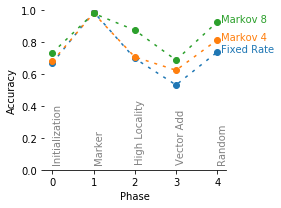

In [83]:
ny = 5
cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(figsize=(4,3))

mark = {'Fixed Rate':'+', 'Markov 4':'_',  'Markov 8':'^', 'All':'x'}

for name in acc_mean_df:
    ax.plot(acc_mean_df[name], 
            linestyle=(0, (2,4)),
            marker='o')


ax.set_ylim((0,1))


ax.set_ylabel('Accuracy')
ax.set_xlabel('Phase')
cmap = plt.get_cmap("tab10")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.text( x=4.1, y=acc_mean_df['Fixed Rate'][ny-1], s='Fixed Rate', color=cmap(0))
ax.text( x=4.1, y=acc_mean_df['Markov 4'][ny-1], s='Markov 4', color=cmap(1))
ax.text( x=4.1, y=acc_mean_df['Markov 8'][ny-1], s='Markov 8', color=cmap(2))

ax.text(x=0, y=.05, s='Initialization', rotation=90, color='grey')
ax.text(x=1, y=.05, s='Marker', rotation=90, color='grey')
ax.text(x=2, y=.05, s='High Locality', rotation=90, color='grey')
ax.text(x=3, y=.05, s='Vector Add', rotation=90, color='grey')
ax.text(x=4, y=.05, s='Random', rotation=90, color='grey')
plt.tight_layout()

plt.savefig('DataPMBS20/plots_{}/per-phase-accuracy.pdf'.format(sizel))

In [12]:
%%markdown

## Accuracy Over Time
Let's now take a look at how accuracy changes over the course of a simulation. Does it get worse over time? 

As we're using the small trace, we won't see much here. Please re-run the notebook to get a better large chart. 

The reason a legend isn't generated is because it is hard to place it well. To get a legend, re-run the plot and uncomment the line labeled as such. 
Then grab the legend and paste it onto the plot in a good area. 


## Accuracy Over Time
Let's now take a look at how accuracy changes over the course of a simulation. Does it get worse over time? 

As we're using the small trace, we won't see much here. Please re-run the notebook to get a better large chart. 

The reason a legend isn't generated is because it is hard to place it well. To get a legend, re-run the plot and uncomment the line labeled as such. 
Then grab the legend and paste it onto the plot in a good area. 


In [13]:
interval_len = 10000
def acc_over_time(st1, st2, phase):
    
    t1 = st1.cache_trace[0] # cache trace from st1 
    
    # Just get accesses where were are in phase `phase` and in state is Swapped (2)
    t2_temp = st2[0].cache_trace[0]
    pick_state = t2_temp['state'] == 2
    pick_phase = t2_temp['phase'] == phase
    pick = np.logical_and(pick_state, pick_phase)

    t1_hits = t1['isHit'][pick]
    nintervals = int(len(t1_hits) // interval_len)-1
    
    acc = np.zeros((len(st2), nintervals))

    for j in range(len(st2)):
        t2 = st2[j].cache_trace[0] # cache trace from st2
    
        # Get the hit/miss from each 
        t2_hits = t2['isHit'][pick]
        
        for i in range(nintervals):
            start = i*interval_len
            end   = (i+1)*interval_len
            t1_hits_rest = t1_hits[start:end]
            t2_hits_rest = t2_hits[start:end]
    
            num_correct = np.sum(np.equal(t1_hits_rest, t2_hits_rest))
            acc[j, i] = num_correct / interval_len
    
    mean = np.mean(acc, axis=0)
    std = np.std(acc, axis=0)
    return mean, std

nphases = stats['base'].phase_trace.nphases
name_map={'fr':'Fixed Rate', 'm4': 'Markov 4', 'm8':'Markov 8', 'all':'All'}
all_df = {}
for i in range(nphases):
    data = {}
    for name in stats:
        if name is 'base':
            continue
        data[name_map[name]],_ = acc_over_time(stats['base'], stats[name], i)
    data_df = pd.DataFrame(data)    
    all_df[i] = data_df

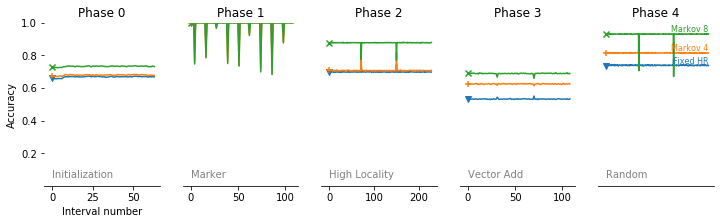

In [15]:
pretty=['Initialization', 'Marker', 'High Locality', 'Vector Add', 'Random']
cmap = plt.get_cmap("tab10")

def acc_over_time_plot(ax, approx, m4, m8, phase):
    ax.plot(approx, label='Fixed Rate')
    ax.plot(m4, label='Markov 4')
    ax.plot(m8, label='Markov 8')    
    ax.set_ylim((0,1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_ticks([])
    ax.set_title('Phase {}'.format(phase))
    ax.text(x=0, y=.05, s=pretty[phase], color='grey')
    
    ax.scatter(0, approx[0], marker='v', color=cmap(0))
    ax.scatter(0, m4[0], marker='+', color=cmap(1))
    ax.scatter(0, m8[0], marker='x', color=cmap(2))
    
    adj_up=.015
    if phase == 4:
        ax.text(len(approx), approx[len(approx)-1]+adj_up, s='Fixed HR', ha='right', size=8, color=cmap(0))
        ax.text(len(m4), m4[len(m4)-1]+adj_up, s='Markov 4', ha='right', size=8, color=cmap(1))
        ax.text(len(m8), m8[len(m8)-1]+adj_up, s='Markov 8', ha='right', size=8, color=cmap(2))
    if phase == 0:
        ax.set_ylabel('Accuracy')
        ax.get_yaxis().set_ticks([.2, .4, .6, .8, 1.])
        ax.set_xlabel('Interval number')
    if phase == 4:
        pass
        #ax.legend(loc=10) ##UNCOMMENT ME FOR LEGEND

fig, ax = plt.subplots(1, 5, figsize=(12,3), squeeze=False)
for phase in range(5):    
    acc_over_time_plot(ax[0,phase], 
          all_df[phase]['Fixed Rate'],
          all_df[phase]['Markov 4'],
          all_df[phase]['Markov 8'],
          phase)
#Remove whitespace around plot
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig('DataPMBS20/plots_{}/acc-over-time.pdf'.format(sizel))
plt.show()


In [77]:
%%markdown

## Accuracy as a function of Model Size

This is just a fun little plot. 


## Accuracy as a function of Model Size

This is just a fun little plot. 


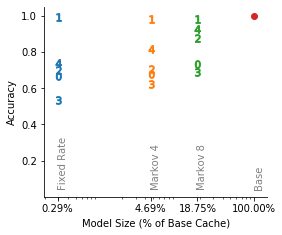

In [18]:
bs=8192
sz = {'base':1, 'fr':24/bs, 'm4':(3 * (4 * 4) * 8)/bs, 'm8':(3 * (8 * 8) * 8)/bs}

fig, ax = plt.subplots(figsize=(4,3.5))

cmap = plt.get_cmap("tab10")
for i in range(5):
    ax.scatter([sz['fr']], acc_mean_df['Fixed Rate'][i], marker='${}$'.format(i), color=cmap(0), s=60)
for i in range(5):
    ax.scatter([sz['m4']], acc_mean_df['Markov 4'][i], marker='${}$'.format(i), color=cmap(1), s=60)
for i in range(5):
    ax.scatter([sz['m8']], acc_mean_df['Markov 8'][i], marker='${}$'.format(i), color=cmap(2), s=60)
ax.scatter(1,1,  color=cmap(3))
ax.set_xscale('log')


labs=np.float64([24/bs, (3 * (4 * 4) * 8)/bs, (3 * (8 * 8) * 8)/bs, 1])*100
ax.get_xaxis().set_ticks([24/bs, (3 * (4 * 4) * 8)/bs, (3 * (8 * 8) * 8)/bs, 1])
ax.set_xticklabels(['{:.2f}%'.format(labs[i]) for i in range(4)])

ax.get_yaxis().set_ticks([.2,.4,.6, .8, 1])

ax.set_xlabel('Model Size (% of Base Cache)')
ax.set_ylabel('Accuracy')
ax.set_ylim(0,1.05)
ax.set_xlim(0,1.5)
ax.text(x=labs[0]/100, y=.05, s='Fixed Rate', rotation=90, color='grey')
ax.text(x=labs[1]/100, y=.05, s='Markov 4', rotation=90, color='grey')
ax.text(x=labs[2]/100, y=.05, s='Markov 8', rotation=90, color='grey')
ax.text(x=labs[3]/100, y=.05, s='Base', rotation=90, color='grey')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#ax.set_title('Points are Phase Numbers', size=10)
#fig.suptitle('Accuracy as a function of Model Size')

plt.savefig('DataPMBS20/plots_{}/acc_vs_modelsize.pdf'.format(sizel))

plt.show()

In [20]:
%%markdown

# Model Scores


# Model Scores


In [71]:
#stats['all'][0].phase_obj[0][4].score_history.get()
d = np.zeros((5,3))
for phase in stats['all'][0].phase_obj[0]:
    if phase == -1:
        continue
    for i in range(3):
        d[phase,i] = stats['all'][0].phase_obj[0][phase].score_history.get()[1][i]

d = np.transpose(d)
names={0:'Fixed Rate', 1:'Markov 4', 2:'Markov 8'}

def score_table(df):
    s = "\\begin{table}\n"
    s += "\\caption{Model Scores (lower is better)}\\label{tab:scores}\n"
    s += "\\begin{tabularx}{\\linewidth}{|l|X|X|X|X|X|}\n"
    s += "\\hline{}\n"
    s += " & Phase 0 & Phase 1 & Phase 2 & Phase 3 & Phase 4 \\\\ \\hline\\hline\n"
    for i in range(len(d)):
        s += "{} & {:.4f} & {:.4f} & {:.4f} & {:.4f} & {:.4f} \\\\ \\hline\n".format(names[i], d[i][0], d[i][1], d[i][2], d[i][3], d[i][4])
    s += "\\end{tabularx}\n\\end{table}\n"
    return s


print(score_table(d))

\begin{table}
\caption{Model Scores (lower is better)}\label{tab:scores}
\begin{tabularx}{\linewidth}{|l|X|X|X|X|X|}
\hline{}
 & Phase 0 & Phase 1 & Phase 2 & Phase 3 & Phase 4 \\ \hline\hline
Fixed Rate & 0.6875 & 0.0626 & 0.6035 & 0.9273 & 0.5188 \\ \hline
Markov 4 & 0.6519 & 0.0781 & 0.6070 & 0.7479 & 0.3842 \\ \hline
Markov 8 & 0.5802 & 0.2253 & 0.3313 & 0.6659 & 0.2668 \\ \hline
\end{tabularx}
\end{table}



In [49]:
%%markdown

## Locality Analysis

Finally, we get to the hardest plot to generate, the locality plot. 


## Locality Analysis

Finally, we get to the hardest plot to generate, the locality plot. 


In [80]:
def index(array, item):
    for idx, val in enumerate(array):
        if val == item:
            return idx
    return -1

def rightshift(val: np.uint64, shift: np.uint64) -> np.uint64:
    return val >> shift

def reuse(trace, shift, outfile=None):
    stack = np.array([], dtype=np.int64)
    out = []
    for i in tqdm(range(len(trace))):
        addr = rightshift(trace[i], np.uint64(shift)) # Cache line
        idx = index(stack, addr)
        if idx == -1:
            stack = np.insert(stack, 0, addr)
        else:
            out.append(idx)
            stack = np.delete(stack, idx)
            stack = np.insert(stack, 0, addr)

    if outfile is not None:
        save_object(out, outfile)
        print('Wrote reuse trace to: {}'.format(outfile))
        
    return out


In [81]:
reuse_perphase_base    = {}
reuse_perphase_approx  = {}
reuse_perphase_markov4 = {}
reuse_perphase_markov8 = {}
gran=6

def get_addrs(data, phase):
    df = pd.DataFrame(data)
    return np.array(df[df['phase']==phase]['addr'], dtype=np.uint64)

for phase in range(0,5):
    reuse_perphase_base[phase] = reuse(get_addrs(stats['base'].cache_trace[1], phase), gran)
    reuse_perphase_approx[phase] = reuse(get_addrs(stats['fr'][0].cache_trace[1], phase), gran)
    reuse_perphase_markov4[phase] = reuse(get_addrs(stats['m4'][0].cache_trace[1], phase), gran)
    reuse_perphase_markov8[phase] = reuse(get_addrs(stats['m8'][0].cache_trace[1], phase), gran)

100%|██████████| 9910/9910 [00:08<00:00, 1126.22it/s]
0it [00:00, ?it/s]
100%|██████████| 526050/526050 [01:00<00:00, 8706.46it/s] 


In [2]:
reuse_perphase_base=sim.load_object('reuse_backup/reuse_perphase_base.pkl')
reuse_perphase_approx=sim.load_object('reuse_backup/reuse_perphase_approx.pkl')
reuse_perphase_markov4=sim.load_object('reuse_backup/reuse_perphase_markov4.pkl')
reuse_perphase_markov8=sim.load_object('reuse_backup/reuse_perphase_markov8.pkl')

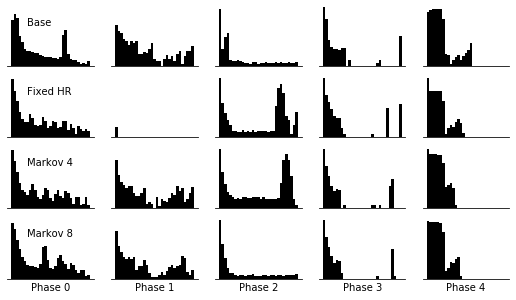

In [32]:
binwidth=16
#maxbin={1:50, 2:850, 3:225, 4:50}
mb=500
maxbin={0:mb,1:mb, 2:mb, 3:mb, 4:mb}

yl=125000
ylim={0:yl,1:yl, 2:yl, 3:yl, 4:yl}


def bins(data, binwidth, maxbin):
    #return range(min(data), min(maxbin, max(data) + binwidth), binwidth)
   # print(data)
    return range(min(data), maxbin, binwidth)

def plot(ax, data, title, phase, plot_labels=False):
    if not data:
        data = [1]
    ax.hist(data, bins=bins(data, binwidth, maxbin=maxbin[phase]), color='black')
    ax.set_yscale('log')
    ax.set_ylim((0,ylim[phase]))
    #ax.suptitle(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    ax.set_xticklabels([''])
    #ax.get_yaxis().set_ticks([30000])


    if plot_labels:
        ax.set_yticklabels(['30k'])

    
#plot(reuse_perphase_base[1], 'Base Cache', maxbin=maxbin[1])
#plot(reuse_perphase_approx[1], 'Fixed Rate Cache', maxbin=maxbin[1])
#plot(reuse_perphase_markov4[1], '4-State Markov Cache', maxbin=maxbin[1])
#plot(reuse_perphase_markov8[1], '8-State Markov Cache', maxbin=maxbin[1])

#i = 1

fig, ax = plt.subplots(4, 5, figsize=(9,5))
for i in range(5):
    #phase = i+1
    phase=i
    
    plot(ax[0,i], reuse_perphase_base[phase], 'Base Cache', phase, plot_labels=(phase==0))
    plot(ax[1,i], reuse_perphase_approx[phase], 'Fixed Rate Cache', phase)
    plot(ax[2,i], reuse_perphase_markov4[phase], '4-State Markov Cache', phase)
    plot(ax[3,i], reuse_perphase_markov8[phase], '8-State Markov Cache', phase)

for i in range(5):
    ax[3,i].text(s='Phase {}'.format(i), y=-.2, x=.5, ha='center', transform=ax[3,i].transAxes)
    
    
ax[0,0].text(s='Base', y=10000,x=100, size=10)
ax[1,0].text(s='Fixed HR', y=10000,x=100, size=10)
ax[2,0].text(s='Markov 4', y=10000,x=100, size=10)
ax[3,0].text(s='Markov 8', y=10000,x=100, size=10)

#fig.suptitle('Per-Phase Reuse Distance')
plt.savefig('DataPMBS20/plots_{}/locality_per_phase.pdf'.format(sizel))
plt.show()

In [18]:
sim.save_object(reuse_perphase_base, 'reuse_backup/reuse_perphase_base.pkl')
sim.save_object(reuse_perphase_approx, 'reuse_backup/reuse_perphase_approx.pkl')
sim.save_object(reuse_perphase_markov4, 'reuse_backup/reuse_perphase_markov4.pkl')
sim.save_object(reuse_perphase_markov8, 'reuse_backup/reuse_perphase_markov8.pkl')

In [119]:
%%markdown

# Error in L1/L2/L3 hits


# Error in L1/L2/L3 hits


In [150]:
def get_stats(stats):
    return np.array([stats.hitcount[0], stats.hitcount[1], stats.hitcount[2], stats.total_cycles])


base = get_stats(stats['base'])

acc2 = {}
for name in stats:
    if name is 'base':
        continue
        
    dat = np.zeros((len(stats['fr']), 4))
    
    for i, st in enumerate(stats[name]):
        dat[i,:] = get_stats(st)
        
    tmp = np.mean(dat, axis=0)
    
    tmp = [100*(tmp[i] - base[i]) / base[i] for i in range(len(tmp))]
    
    acc2[name]=tmp
            
names={'all':'ALL', 'm8':'Markov 8', 'm4':'Markov 4', 'fr':'Fixed Hit Rate'}
        
def latex_loc_stats(df):
    s = "\\begin{table}\n"
    s += "\\caption{Percent Change in Cache Stats}\\label{tab:loc_stats}\n"
    s += "\\begin{tabularx}{\\linewidth}{|l|X|X|X||X|}\n"
    s += "\\hline{}\n"
    s += " & L1 Hits & L2 Hits & L3 Hits & Cycles  \\\\ \\hline\\hline\n"        
    s += "{} & {:.2e} & {:.2e} & {:.2e} & {:.2e} \\\\ \\hline\\hline\n".format('Base', base[0], base[1], base[2], base[3])
    for i in df:
        s += "{} & {:.2f}\\% & {:.2f}\\% & {:.2f}\\% & {:.2f}\\% \\\\ \\hline\n".format(names[i], df[i][0], df[i][1], df[i][2], df[i][3])
    s += "\\end{tabularx}\n\\end{table}\n"
    return s
print(latex_loc_stats(acc2))


\begin{table}
\caption{Percent Change in Cache Stats}\label{tab:loc_stats}
\begin{tabularx}{\linewidth}{|l|X|X|X||X|}
\hline{}
 & L1 Hits & L2 Hits & L3 Hits & Cycles  \\ \hline\hline
Base & 7.69e+06 & 7.78e+05 & 2.53e+05 & 1.37e+08 \\ \hline\hline
Fixed Hit Rate & -0.07\% & 54.11\% & -71.11\% & -27.91\% \\ \hline
Markov 4 & -0.37\% & 46.10\% & -52.14\% & -23.13\% \\ \hline
Markov 8 & -0.19\% & 12.13\% & -4.18\% & -7.59\% \\ \hline
ALL & 0.07\% & 10.12\% & -4.65\% & -7.99\% \\ \hline
\end{tabularx}
\end{table}

